In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Merge
from keras.layers.core import Flatten, Reshape, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling1D
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback as KerasCallback
import numpy as np
import cv2
import random as rand
from numpy import genfromtxt
import ntpath


Using TensorFlow backend.


In [2]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.5):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

In [3]:
"""
Suffle multiple arrays with respect of its indexing
Args:
    arrs: list of arrays of same length
Returns:
    list of shuffled arrays
"""
def shuffle_arrs (arrs):
    p = np.random.permutation (len(arrs[0]))
    return [arr[p] for arr in arrs]

"""
Removes specified @proportion of records which satisfies condition from given arrays (@arrs)
with respect of its indexing. Removing is based on specified array (@arr_idx) values.
Values of array are testing with @condition_lambda and dividing into two parts.
First part that satisfies @condition_lambda and second which is not.
Next first part is suffled and sparsed by @proportion, concatenated with second and returned.
Other array values will be sparsed correspondingly

You can use this function to remove portion of records with some specific values from
dataset represented by list of arrays

Args:
    proportion: floating point value from 0 to 1
    condition_lambda: lambda which will be used fot testing values of specified array
    arr_idx: index in array list which points to array that will be used for selecting values
    arrs: list of arrays

Returns:
    list of arrays
"""
def sparse_arrays_by_first_array_value (proportion, condition_lambda, arr_idx, arrs):
    
    target_arr = arrs [arr_idx]
    idx_less = np.where(condition_lambda(target_arr))
    idx_greater = np.where(np.logical_not(condition_lambda(target_arr)))

    less_arrs = [arr[idx_less] for arr in arrs]
    greater_arrs = [arr[idx_greater] for arr in arrs]

    less_arrs = shuffle_arrs (less_arrs)

    proportion_count = int(proportion * len (less_arrs[arr_idx]))
    less_arrs = [less_arr[0:proportion_count] for less_arr in less_arrs]

    retarrs = [np.concatenate ((less_arr, greater_arr)) for less_arr, greater_arr in zip(less_arrs, greater_arrs)]
    
    return retarrs

"""
Splits specified list of arrays in specified proportion
Args:
    arrs: list of arrays
    test_size: floating point value from 0 to 1 representing test dataset proportion
Returns:
    tuple of list of arrays
    first list is train dataset
    second is test dataset
"""
def train_test_split (arrs, test_size):
    arrs = shuffle_arrs (arrs)
    test_size_count = int ((1.0-test_size) * len(arrs[0]))
    train = [arr[0:test_size_count] for arr in arrs]
    test = [arr[test_size_count:] for arr in arrs]
    return train, test

"""
Loads datasets from CSV file, doesn't load images
Args:
    datasets: list of
        strings - dataset dir path or
        tuples - (dataset dir path, floating point proportion of dataset needed to be loaded)
        
    for example:
        ['dir/path', ('dir/path', 0.5)]
Returns:
    tuple of two arrays:
        steering wheel data array,
        camera image path array
"""
def load_datasets (datasets):
    all_steering = np.zeros ((0,))
    all_center = np.zeros ((0,))
    for dataset in datasets:
        dataset_file = ''
        dataset_size = 1
        if (isinstance(dataset, tuple)):
            dataset_file = dataset [0]
            dataset_size = dataset [1]
        else:
            dataset_file = dataset
        
        driving_log = genfromtxt (
            dataset_file + '/driving_log.csv',
            delimiter=',',
            skip_header=1,
            dtype=None)

        #center, left, right, steering, throttle, break, speed
        indices = range (len(driving_log))
        center, left, right, steering, throttle, breakvals, speed = zip (*driving_log)
        center = np.asarray (center)
        steering = np.asarray (steering)
        
        if (dataset_size < 1):
            arrs, not_needed = train_test_split ([steering, center], test_size=1-dataset_size)
            steering, center = arrs

        all_steering = np.concatenate([all_steering, steering])
        all_center = np.concatenate([
                all_center,
                np.core.defchararray.add(
                    dataset_file + '/IMG/',
                    np.asarray (
                            [ntpath.basename (path) for path in np.core.defchararray.decode(center)]
                        )
                )
            ])

    return all_steering, all_center

In [4]:
#loading needed datasets

#datasets with straight steering
datasets = ['record-backward', 'record-forward', 'record-backward-2', 'record-forward-2']

steering, center_camera = load_datasets (datasets)

#datasets with recovering from left divergence
steering_lr, center_camera_lr = load_datasets ([
        #strong divergence, using only 1/4 of the dataset
        ('record-left-recover', 0.5),
        #medium divergence
        ('record-left-recover/2', 1),
        #light divergence
        ('record-left-recover/3', 1)
    ])

#datasets with recovering from right divergence
steering_rr, center_camera_rr = load_datasets ([
        ('record-right-recover', 0.5),
        ('record-right-recover/2', 1),
        ('record-right-recover/3', 1),
    ])

#remove steering that less than 0 for recover from left dataset
#so removing divergence steering and staying only recovering steering
arrs = sparse_arrays_by_first_array_value (0, lambda v: v < 0, 0, [steering_lr, center_camera_lr])
steering_lr, center_camera_lr = arrs

#remove steering that greater than 0 for recover dataset
arrs = sparse_arrays_by_first_array_value (0, lambda v: v > 0, 0, [steering_rr, center_camera_rr])
steering_rr, center_camera_rr = arrs

#joining datasets
steering = np.concatenate ([steering, steering_lr, steering_rr])
center_camera = np.concatenate ([center_camera, center_camera_lr, center_camera_rr])

#We discussed proj 3 in our study group and I decided to filter steering wheel values around zero,
#as it dominates in the dataset
arrs = sparse_arrays_by_first_array_value (0.1, lambda v: abs(v) < 1e-5, 0, [steering, center_camera])
steering, center_camera = arrs

print (len (steering), len (center_camera))

12123 12123


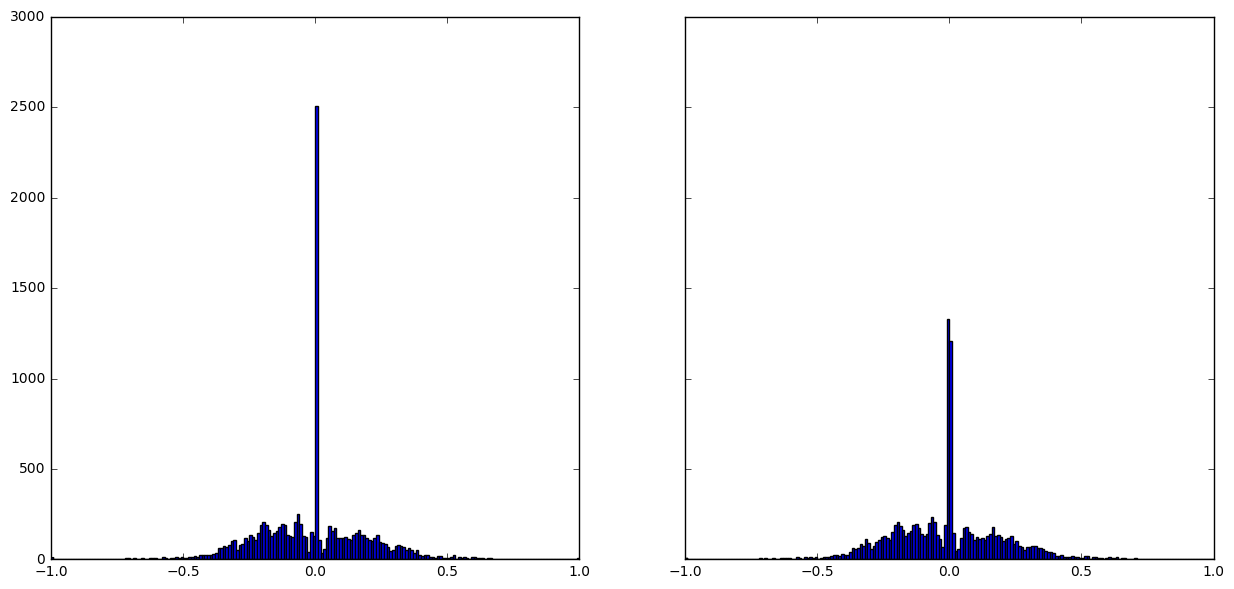

In [5]:
import matplotlib.pyplot as plt

fig, imtable = plt.subplots (1, 2, figsize = (15, 7), sharex=True, sharey=True)

imtable[0].hist(steering, bins=200, range=(-1,1))
imtable[1].hist(steering + np.random.normal (0, 0.005, size=(len(steering))), bins=200, range=(-1,1))

plt.show ()

%matplotlib inline

-0.5 0.5
steering -1.0 1.0


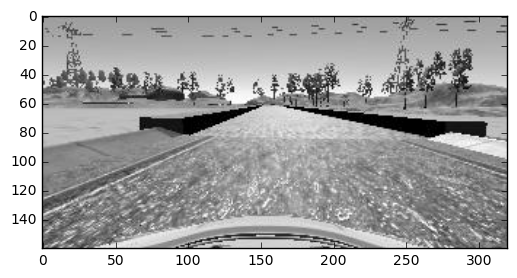

In [6]:
#loading dataset images
"""
Loades dataset images
Args:
    paths: arrays of image paths
Returns:
    numpy arrays of grayscaled, normalized images,
    pixel values are in range (-0.5, 0.5)
"""
def load_images (paths):
    dataset_images = []
    for path in paths:
        im = cv2.imread (path, cv2.IMREAD_GRAYSCALE)
        im = np.subtract(np.divide(np.array(im).astype(np.float32), 255.0), 0.5)
        dataset_images.append (im)
    return np.array (dataset_images)

dataset_images = load_images (center_camera)
print (np.min (dataset_images [0]), np.max (dataset_images [0]))
print ('steering', np.min(steering), np.max(steering))

plt.figure ()
plt.imshow (dataset_images [2000], cmap='gray')
plt.show ()

-0.0968063488332 -0.608296 0.386924


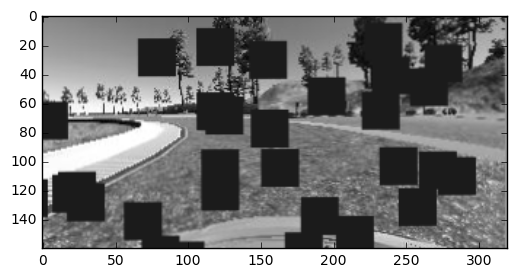

-0.125466116089 -0.523397 0.476603


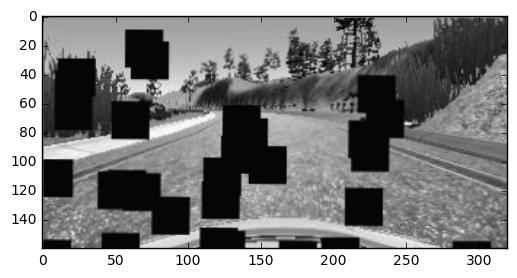

-0.00345836837932 -0.605686 0.386777


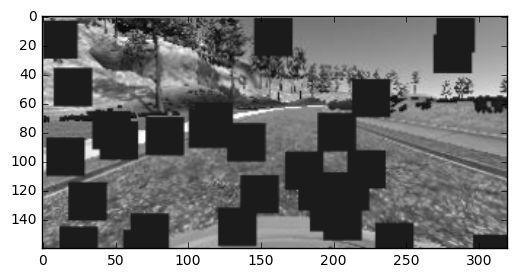

In [7]:
#defining augmentation of the dataset
"""
Image augmentation function.
It creates new image with
    - randomized brightness (-0.3, 0.3)
    - randomly partially occluded with 30
        black 25x25 px squares
    - very slightely randomly:
        - rotated (1 degree)
        - shifted (2px)
        - scaled (0.02)

Args:
    image: base image for generation new one
Returns:
    newly generatied image
"""
def augment_image (image):

    image = np.copy (image)
    
    (h, w) = image.shape[:2]
    
    #randomize brightness
    brightness = rand.uniform (-0.3, 0.3)
    image = np.add(image, brightness)
    
    #random squares
    rect_w = 25
    rect_h = 25
    rect_count = 30
    for i in range (rect_count):
        pt1 = (rand.randint (0, w), rand.randint (0, h))
        pt2 = (pt1[0] + rect_w, pt1[1] + rect_h)
        cv2.rectangle(image, pt1, pt2, (-0.5, -0.5, -0.5), -1)
    
    #rotation and scaling
    rot = 1
    scale = 0.02
    Mrot = cv2.getRotationMatrix2D((h/2,w/2),rand.uniform(-rot, rot), rand.uniform(1.0 - scale, 1.0 + scale))

    #affine transform and shifts
    pts1 = np.float32([[0,0],[w,0],[w,h]])
    a = 0
    shift = 2
    shiftx = rand.randint (-shift, shift);
    shifty = rand.randint (-shift, shift);
    pts2 = np.float32([[
                0 + rand.randint (-a, a) + shiftx,
                0 + rand.randint (-a, a) + shifty
            ],[
                w + rand.randint (-a, a) + shiftx,
                0 + rand.randint (-a, a) + shifty
            ],[
                w + rand.randint (-a, a) + shiftx,
                h + rand.randint (-a, a) + shifty
            ]])
    M = cv2.getAffineTransform(pts1,pts2)

    augmented = cv2.warpAffine(
            cv2.warpAffine (
                image
                , Mrot, (w, h)
            )
            , M, (w,h)
        )
    
    return augmented

"""
Augments image basing on input image with augment_image.
Also randomly flips image and steering wheel correspondingly.
Also adds normal noise (0, 0.005) to steering angle
Args:
    im: image
    steering: steering wheel angle
Returns:
    tuple:
        image,
        steering wheel
"""
def augment_record (im, steering):
    im = augment_image(im)
    if (rand.uniform (0, 1) > 0.5):
        im = cv2.flip (im, 1)
        steering = - steering
    steering = steering + np.random.normal (0, 0.005)
    return im, steering

"""
Grenerator for training samples
Args:
    images_arr: train dataset images
    steering_arr: train dataset steering
    batch_size: batch size
Returns:
    Only generated batch of samples, not includes original samples
"""
def augment_generator (images_arr, steering_arr, batch_size):
    last_index = len (images_arr) - 1
    while 1:
        batch_img = []
        batch_steering = []
        for i in range (batch_size):
            
            idx_img = rand.randint (0, last_index)
            im, steering = augment_record (images_arr [idx_img], steering_arr[idx_img])
            
            batch_img.append (im)
            batch_steering.append (steering)
            
        batch_img = np.asarray (batch_img)
        batch_steering = np.asarray (batch_steering)
        yield (batch_img, batch_steering)

g = augment_generator (dataset_images, steering, 3)
xs, ys = next(g)

for im, y in zip (xs, ys):
    print (y, np.min (im), np.max (im))
    plt.figure ()
    plt.imshow (im, cmap='gray')
    plt.show ()


In [8]:
#defining NN architecture

model = Sequential ([
        Reshape ((160, 320, 1), input_shape=(160, 320)),
        
        Convolution2D (24, 8, 8, border_mode='valid'),
        MaxPooling2D (pool_size=(2, 2)),
        Dropout (0.5),
        Activation ('relu'),

        #77x157
        Convolution2D (36, 5, 5, border_mode='valid'),
        MaxPooling2D (pool_size=(2, 2)),
        Dropout (0.5),
        Activation ('relu'),

        #37x77
        Convolution2D (48, 5, 5, border_mode='valid'),
        MaxPooling2D (pool_size=(2, 2)),
        Dropout (0.5),
        Activation ('relu'),

        #17x37
        Convolution2D (64, 3, 3, border_mode='valid'),
        MaxPooling2D (pool_size=(2, 2)),
        Dropout (0.5),
        Activation ('relu'),

        #8x18
        Convolution2D (64, 2, 2, border_mode='valid'),
        MaxPooling2D (pool_size=(2, 2)),
        Dropout (0.5),
        Activation ('relu'),

        #4x9
        Flatten (),
        
        Dense (1024),
        Dropout (0.5),
        Activation ('relu'),

        Dense (512),
        Dropout (0.5),
        Activation ('relu'),

        Dense (256),
        Activation ('relu'),
        
        Dense (128),
        Activation ('relu'),
        
        Dense (32),
        Activation ('tanh'),
        
        Dense (1)
])

optimizer = Adam (lr=1e-4)

model.compile (
    optimizer=optimizer,
    loss='mse',
    metrics=[]
)

steering_angle = np.array(model.predict(dataset_images [0:2700:400], batch_size=1))
print (steering_angle)

[[-0.00017485]
 [-0.00025001]
 [-0.00018094]
 [-0.00012286]
 [-0.00013794]
 [-0.00012251]
 [-0.00010782]]


In [9]:
#training

#splitting into train and validation dataset
train, valid = train_test_split ([dataset_images, steering], test_size=0.33)
train_dataset_images, train_steering = train
valid_dataset_images, valid_steering = valid

print (len(train_dataset_images), len (valid_dataset_images))

batch_size = 112
epochs = 30

class SaveModel(KerasCallback):
    def on_epoch_end(self, epoch, logs={}):
        epoch += 1
        with open ('model-' + str(epoch) + '.json', 'w') as file:
            file.write (model.to_json ())
            file.close ()

        model.save_weights ('model-' + str(epoch) + '.h5')

model.fit_generator (
    augment_generator(train_dataset_images, train_steering, batch_size),
    samples_per_epoch=400*112,
    nb_epoch=epochs,
    validation_data=(valid_dataset_images, valid_steering),
    callbacks = [SaveModel ()]
)

steering_test, center_camera_test = load_datasets (['record-test'])
images_test = load_images (center_camera_test)
loss = model.evaluate (images_test, steering_test)
print ('test loss: ', loss)


8122 4001
Epoch 1/30
 5600/44800 [==>...........................] - ETA: 70s - loss: 0.0499

KeyboardInterrupt: 